This file contains the necessary code to interactively explore the output of the model, and recreate the figures from the paper, using the best fit parameters obtained after running `parameter_estimation.py`.

Uncomment the `plt.savefig()` lines to overwrite the existing figures.

**Note:** this notebook was elaborated with Python 2.7 and the label generation requires LaTeX.

---

Row-wise subplot titles using phantom background plot adapted from [here](https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot).

In [1]:
# We import the necessary packages
import warnings
warnings.filterwarnings('ignore')

from functions_global import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
plt.style.use('seaborn')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [2]:
# We load the raw data
dataRaw = pd.read_csv('../../data/VNA.csv')
timesData = dataRaw['days'].tolist() # List of time points
nMeasurements = 4

# We construct the arrays of data for each vaccine formulation
PBS = []  # Non-adjuvanted vaccine
MF59 = []  # Vaccine with MF59
AS03 = []  # Vaccine with AS03
Diluvac = []  #Vaccine with Diluvac
X_data = [] # List of (repeated) time points

for i in range(len(timesData)):
    for j in range(1,nMeasurements+1):
        X_data.append(timesData[i])
        PBS.append(dataRaw.T.iloc[j][i])
    for j in range(nMeasurements+1,2*nMeasurements+1):
        MF59.append(dataRaw.T.iloc[j][i])
    for j in range(2*nMeasurements+1,3*nMeasurements+1):
        AS03.append(dataRaw.T.iloc[j][i])
    for j in range(3*nMeasurements+1,4*nMeasurements+1):
        Diluvac.append(dataRaw.T.iloc[j][i])
X_data = np.array(X_data)
PBS = np.array(PBS)
MF59 = np.array(MF59)
AS03 = np.array(AS03)
Diluvac = np.array(Diluvac)
y_data = [PBS, MF59, AS03, Diluvac]

In [3]:
# We load the best fit parameters (base from model A)
params_base = pd.Series.from_csv('../../params/best_fit_params_base_A.csv')
params_adj = pd.read_csv('../../params/best_fit_params_adj_Astar.csv', index_col=0).set_index('adjuvant')
gammaNA, gammaHA, mu, dmax = params_base['gammaNA'], params_base['gammaHA'], params_base['mu'], params_base['dmax']

adjuvants = params_adj.index.get_values()
betaNA_list = []
betaHA_list = []
betaAb_list = []
for adj in adjuvants:
    betaNA_list.append(params_adj.loc[adj]['betaNA'])
    betaHA_list.append(params_adj.loc[adj]['betaHA'])
    betaAb_list.append(params_adj.loc[adj]['betaAb'])

In [4]:
# We integrate the PDEs for each vaccine formulation
X_model = np.arange(0, timeStop + dt, 1.0)
model_output = []
total_Ab = []

# Base
baseQ = vQ0(np.abs(grid), dmax) + vQ0(np.abs(1 - grid), dmax)
H = Htilde*0.5*(np.sign(grid - 0.99*dmax) + np.sign(1.0 - 0.99*dmax - grid))
Q_PBS = gammaNA*vQ0(abs(grid), dmax) + gammaHA*vQ0(abs(1 - grid), dmax)
y0 = np.zeros(2*Nx)
y0[1 :: 2] = np.ones(Nx)
sol_PBS = odeint(affinityMaturation, y0, t, args=(t_boost, H, baseQ, Q_PBS, ktilde, mu, dx), ml=2, mu=2)
model_output.append(sol_PBS)
total_Ab.append(np.array([np.sum(sol_PBS[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model]))

# Adjuvants
for i in range(len(adjuvants)):
    Q_adj = (gammaNA*betaNA_list[i]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[i]*vQ0(np.abs(1 - grid), dmax))
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    sol_adj = odeint(affinityMaturation, y0, t, args=(t_boost, H, baseQ, Q_adj, ktilde*betaAb_list[i], mu, dx), ml=2, mu=2)
    model_output.append(sol_adj)
    total_Ab.append(np.array([np.sum(sol_adj[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model]))

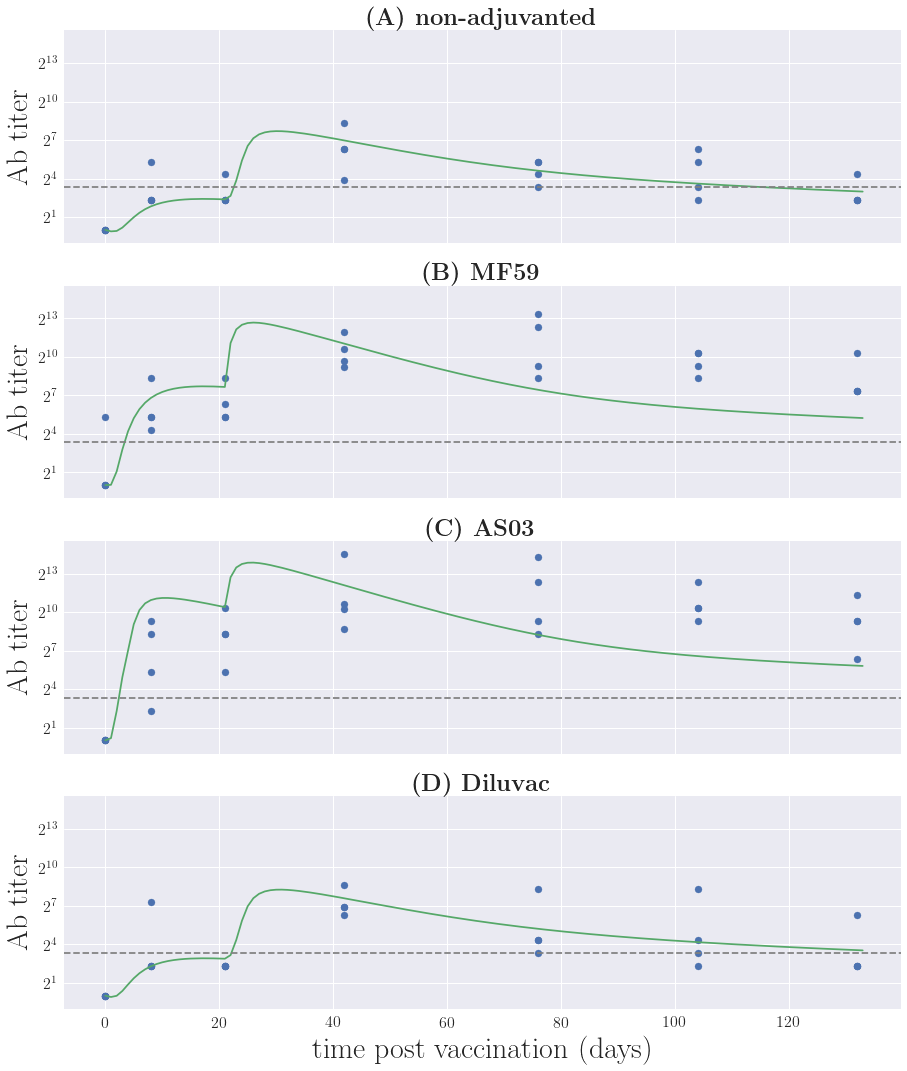

In [5]:
# We plot the data and the model output for every case

# These two lines create a list containing the default colour cycle in the style
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

f, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(15,18))
config = np.append(['non-adjuvanted'],adjuvants)
figlabels = [r'\bf{(A)} ', r'\bf{(B)} ', r'\bf{(C)} ', r'\bf{(D)} ']
axes[3].set_xlabel('time post vaccination (days)', fontsize=30)
for i in range(4):
    axes[i].tick_params(labelsize=16)
    axes[i].set_ylabel('Ab titer', fontsize=30)
    axes[i].set_yscale('log', basey=2)
    axes[i].set_title(figlabels[i]+config[i],fontsize=24)
    axes[i].scatter(X_data, y_data[i])
    axes[i].plot(X_model, total_Ab[i],color=colours[1])
    axes[i].axhline(y=10,color='grey',linestyle='--')
    
# Uncomment line below to save a new version of the figure    
# plt.savefig('../../figures/Astar_Ab_vs_t.pdf',bbox_inches='tight')

In [6]:
# Visualising best fit parameters
params_base=params_base.rename('non-adjuvanted')
params_all=params_adj.append(params_base)
params_all.index.names = ['formulation']
params_all = params_all.reindex(config)
params_all = params_all.fillna('-')
params_all

,betaAb,betaHA,betaNA,dmax,gammaHA,gammaNA,mu
formulation,,,,,,,
non-adjuvanted,-,-,-,0.105761,7.09991,2.43451,0.46016
MF59,1,2.92827,8.26043,-,-,-,-
AS03,1,4.50645,11.5455,-,-,-,-
Diluvac,1,1.00017,2.40732,-,-,-,-
